### Workflow for predicting TFs to perturb for a specific transition

In [1]:
import sys
import numpy as np
import pandas as pd
sys.path.append('../model/')

%load_ext autoreload
%autoreload 2

from data import prescient_data
from plot import make_bar_plot, make_error_plot
import scanpy as sc

/dfs/user/yhr/uce/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0. Read in and set up data

In [3]:
scvi_data = sc.read_h5ad('./workflow_dir/Friedman_reduced.h5ad')

/dfs/user/yhr/uce/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
adata_path = './workflow_dir/Friedman_reduced.h5ad'
adata = sc.read_h5ad(adata_path)

/dfs/user/yhr/uce/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
workflow = prescient_data(adata=adata, path =adata_path, setting='scvi')

Loading preprocessed data...


/dfs/user/yhr/uce/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


### 1. Run batch effect correction (if needed)

In [5]:
## Run batch effect correction

workflow.set_up_scvi(batch_key='day')
workflow.scvi_plot_setup()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/dfs/user/yhr/uce/lib/python3.10/site-p

Epoch 237/400:  59%|██████████████▏         | 237/400 [02:33<01:45,  1.54it/s, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=921]
Monitored metric elbo_validation did not improve in the last 20 records. Best score: 939.400. Signaling Trainer to stop.


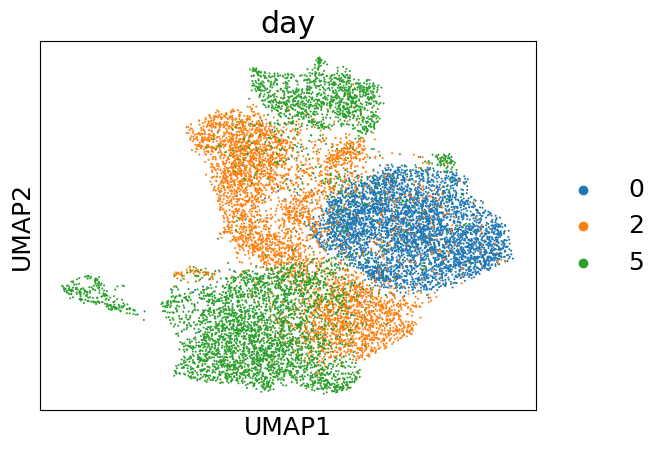

In [6]:
sc.pl.umap(workflow.adata, color='day')

### Using cell type labels

In [8]:
cell_barcodes = {}
cell_barcodes['stem'] = adata[adata.obs.label == 'stem'].obs.index.values
cell_barcodes['meso'] = adata[adata.obs.label == 'meso'].obs.index.values
cell_barcodes['endo'] = adata[adata.obs.label == 'endo'].obs.index.values

In [9]:
source_target_pairs = [['stem', 'meso'], 
                       ['stem', 'endo'], 
                       ['endo', 'meso'],
                       ['meso', 'endo']]

for source_name, target_name in source_target_pairs:
        
    source_idx=np.where(workflow.adata.obs.index.isin(cell_barcodes[source_name]))[0]
    target_idx=np.where(workflow.adata.obs.index.isin(cell_barcodes[target_name]))[0]
    
    workflow.get_DE(source_idx=source_idx, 
                    target_idx=target_idx,
                    source_name=source_name, target_name=target_name)

DE...: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


In [10]:
## Save differential expression output
## Set DE directory

workflow.write_DE_files(DE_dir='../Data/DE/')

../Data/DE/DE_Friedman_reduced_stem_to_meso.csv
../Data/DE/DE_Friedman_reduced_stem_to_endo.csv
../Data/DE/DE_Friedman_reduced_endo_to_meso.csv
../Data/DE/DE_Friedman_reduced_meso_to_endo.csv


### Read in (or infer) network

In [8]:
## TODO Daniel, add a dropdown or something here which allows users to pick their cell type of interest
workflow.get_network(cell_type='embryonic stem cell')

Network path loaded


### Run PRECICE

In [21]:
# -----------

for source_name, target_name in source_target_pairs:
    print(source_name, target_name)
    transition = source_name +'_to_' + target_name
    workflow.run_prescient(species='human',
                          network_path=self.network_path,
                          DE_path=workflow.DE_filenames[transition])

meso endo
Running command: /dfs/user/yhr/uce/bin/python /dfs/user/yhr/cell_reprogram/model/flow_script.py --p_thresh 2e-2 --hops 3 --species human --adjacency ../Data/edge_weights/G_all_edges_Friedman_1_linear_learntweights.csv --DE_data ../Data/DE/DE_Friedman_reduced_meso_to_endo.csv
no_parallel_p_0.02_max_step_0.1_hops_3_DE_DE_Friedman_reduced_meso_to_endo_adjacency_G_all_edges_Friedman_1_linear_learntweights
Finding best solutions for each value of lambda:


 11%|█         | 10979/100000 [00:14<02:51, 520.43it/s]


Processing:   0%|          | 0/11 [00:28<?, ?it/s]
Traceback (most recent call last):
  File "/dfs/user/yhr/cell_reprogram/model/flow_script.py", line 359, in <module>
    x = f.get_k_perturbation_range(10, save=True, return_all_errors=False)
  File "/dfs/user/yhr/cell_reprogram/model/flow_script.py", line 261, in get_k_perturbation_range
    sol, sol_error, error_interval = self.k_active_sol(k,
  File "/dfs/user/yhr/cell_reprogram/model/flow_script.py", line 174, in k_active_sol
    self.solve()
  File "/dfs/user/yhr/cell_reprogram/model/flow_script.py", line 154, in solve
    expression_lambda = solve(self.A, self.B, self.expression, lambdas,
  File "/dfs/user/yhr/cell_reprogram/model/flow.py", line 161, in solve
    exp_df[str(l)] = solve_lasso(A,B, lamb=l, positive=positive)
  File "/dfs/user/yhr/cell_reprogram/model/flow.py", line 153, in solve_lasso
    clf.fit(A,B)
  File "/dfs/user/yhr/uce/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_metho